In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import dgl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import joblib

In [2]:
nodes= pd.read_csv('/Users/varun/Desktop/LAM/demand_forecasting/static_homogenous/(3)/nodes.csv')
edges = pd.read_csv('/Users/varun/Desktop/LAM/demand_forecasting/static_homogenous/(3)/edges.csv')

In [3]:
nodes

,Unnamed: 0,timestamp,feature,value,node
0,0,0,0,0.229856,0
1,1,1,0,0.490386,0
2,2,2,0,0.386343,0
3,3,3,0,0.281923,0
4,4,4,0,0.370994,0
...,...,...,...,...,...
9995,9995,95,3,-0.026083,24
9996,9996,96,3,0.104901,24
9997,9997,97,3,0.007716,24
9998,9998,98,3,0.285419,24


In [4]:
edges = edges.drop(columns=['Unnamed: 0'])
filtered_edges = edges[edges['value'] == 1]

In [5]:
filtered_edges

,timestamp,source,target,feature,value
4,0,0,4,0,1.0
6,0,0,6,0,1.0
8,0,0,8,0,1.0
9,0,0,9,0,1.0
12,0,0,12,0,1.0
...,...,...,...,...,...
609,0,24,9,0,1.0
612,0,24,12,0,1.0
613,0,24,13,0,1.0
621,0,24,21,0,1.0


In [6]:
G = nx.from_pandas_edgelist(filtered_edges, source='source', target='target', edge_attr=True, create_using=nx.DiGraph())

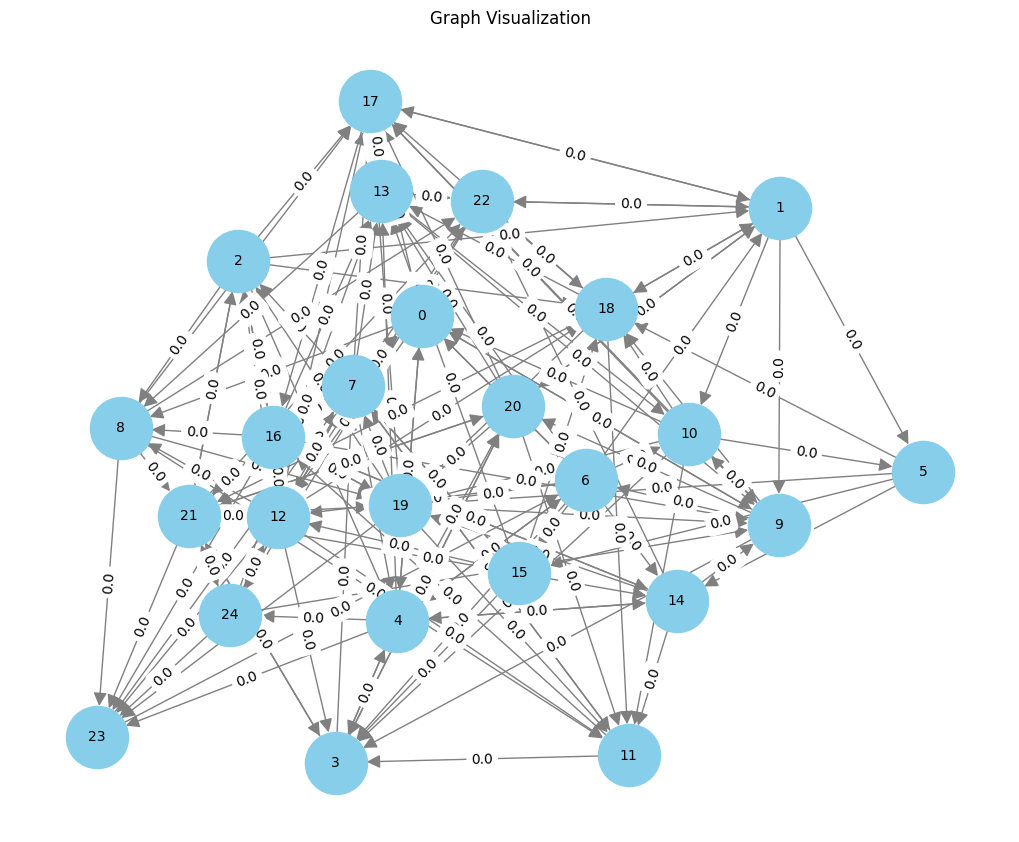

In [7]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, arrowstyle='-|>', arrowsize=20, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(row['source'], row['target']): row['feature'] for idx, row in filtered_edges.iterrows()})
plt.title('Graph Visualization')
plt.show()

In [8]:
src = filtered_edges['source'].to_numpy()
dst = filtered_edges['target'].to_numpy()

In [9]:
timestamp_graphs={}

In [10]:
for timestamp, group in nodes.groupby('timestamp'):
    feat1 = group[group['feature'] == 0].set_index('node')['value']
    feat2 = group[group['feature'] == 1].set_index('node')['value']
    feat3 = group[group['feature'] == 2].set_index('node')['value']
    feat4 = group[group['feature'] == 3].set_index('node')['value']
    
    # dgl graph
    g = dgl.graph((src, dst))
    
    # Initialize feature matrix with zeros
    num_nodes = g.num_nodes()
    features = np.zeros((num_nodes, 4))
    
    # feature 1 : cost, feature 2: requirement of product
    features[feat1.index, 0] = feat1
    features[feat2.index, 1] = feat2
    features[feat3.index, 2] = feat3
    features[feat4.index, 3] = feat4
    features = torch.FloatTensor(features)
    
    g.ndata['feat'] = features
    timestamp_graphs[timestamp] = g


In [23]:
timestamps = sorted(timestamp_graphs.keys(), key=lambda x: x)

In [11]:
timestamp_graphs

{0: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 1: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 2: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 3: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 4: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 5: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 6: Graph(num_nodes=25, num_edges=157,
       ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}),
 7: Graph(num_nodes=25, num_edges=157,
       nd

In [24]:
train_timestamps = timestamps[0:int(0.8*len(timestamps))]
test_timestamps = timestamps[int(0.8*len(timestamps)):]

In [25]:
train_graphs = []
test_graphs = []
train_labels = []
test_labels = []

In [26]:
for timestamp in train_timestamps:
    train_graphs.append(timestamp_graphs[timestamp])
    train_labels.append(timestamp_graphs[timestamp].ndata['feat'][:, 3].unsqueeze(0))

for timestamp in test_timestamps:
    test_graphs.append(timestamp_graphs[timestamp])
    test_labels.append(timestamp_graphs[timestamp].ndata['feat'][:, 3].unsqueeze(0))

In [29]:
class TemporalGNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_layers):
        super(TemporalGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GraphConv(in_feats, hidden_feats))
        for _ in range(num_layers - 1):
            self.convs.append(GraphConv(hidden_feats, hidden_feats))
        self.rnn = nn.GRU(hidden_feats, hidden_feats, batch_first=True)
        self.fc = nn.Linear(hidden_feats, out_feats)
    
    def forward(self, g, features):
        h = features
        for conv in self.convs:
            h = F.relu(conv(g, h))
        
        h = h.unsqueeze(1)  # Add time dimension
        out, _ = self.rnn(h)
        out = self.fc(out[:, -1, :])
        return out

In [30]:
model = TemporalGNN(in_feats=3, hidden_feats=64, out_feats=1, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [31]:
num_epochs = 50

In [32]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(len(train_graphs)):
        g = train_graphs[i]
        features = g.ndata['feat'][:, :3]  # Use the first three features
        labels = train_labels[i]

        optimizer.zero_grad()
        predictions = model(g, features).squeeze()
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_graphs)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 25])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 0.07089058300480247
Epoch 2/50, Loss: 0.056717809708788994
Epoch 3/50, Loss: 0.057751508662477136
Epoch 4/50, Loss: 0.05610172082670033
Epoch 5/50, Loss: 0.054041724931448695
Epoch 6/50, Loss: 0.05373660381883383
Epoch 7/50, Loss: 0.054023564560338855
Epoch 8/50, Loss: 0.05369990942999721
Epoch 9/50, Loss: 0.05311134536750615
Epoch 10/50, Loss: 0.05279051177203655
Epoch 11/50, Loss: 0.05238051344640553
Epoch 12/50, Loss: 0.052119529247283934
Epoch 13/50, Loss: 0.051796175097115336
Epoch 14/50, Loss: 0.05119516320992261
Epoch 15/50, Loss: 0.051717095728963616
Epoch 16/50, Loss: 0.05075343360658735
Epoch 17/50, Loss: 0.05081889752764255
Epoch 18/50, Loss: 0.05241625576745719
Epoch 19/50, Loss: 0.05007207952439785
Epoch 20/50, Loss: 0.050252618524245916
Epoch 21/50, Loss: 0.049133965955115856
Epoch 22/50, Loss: 0.04868941893801093
Epoch 23/50, Loss: 0.0484750383766368
Epoch 24/50, Loss: 0.0484509923029691
Epoch 25/50, Loss: 0.04805689724162221
Epoch 26/50, Loss: 0.048068

Predictions: [0.41412216 0.54459333 0.3890779  0.49990943 0.37793338 0.13820827
 0.6318036  0.691759   0.34062293 0.5394458  0.46801051 0.34062293
 0.3550065  0.445378   0.5737717  0.62877107 0.70079756 0.37774348
 0.35715285 0.34062293 0.408209   0.34062293 0.34062293 0.34062293
 0.5274851 ]
Actual values: [[0.38707668]
 [0.83647615]
 [0.40607336]
 [0.80487126]
 [0.18419003]
 [0.28932616]
 [0.6410402 ]
 [0.89552206]
 [0.8714573 ]
 [0.6732552 ]
 [0.6842976 ]
 [0.36217377]
 [0.27283093]
 [0.34310386]
 [0.90905243]
 [0.93422836]
 [0.97549903]
 [0.28765425]
 [0.9021238 ]
 [0.580551  ]
 [0.06530707]
 [0.05222427]
 [0.44423935]
 [0.12318775]
 [0.37096068]]


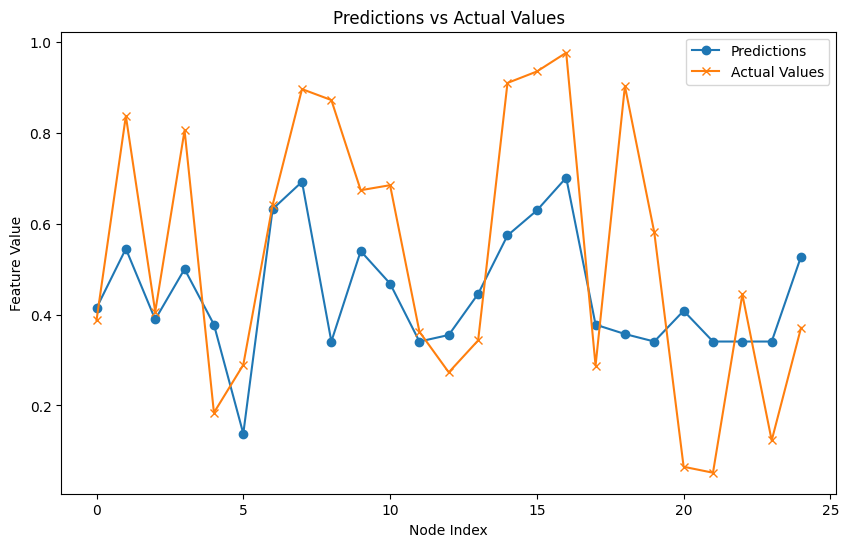

In [33]:
model.eval()
with torch.no_grad():
    test_graph = timestamp_graphs[timestamps[-1]]
    test_features = test_graph.ndata['feat'][:,:3]
    predictions = model(test_graph, test_features).squeeze()
    
    # Get actual values
    actual_values = test_graph.ndata['feat'][:,-1:]
    print("Predictions:", predictions.numpy())
    print("Actual values:", actual_values.numpy())

    predictions_np = predictions.numpy()
    actual_values_np = actual_values.numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(predictions_np, label='Predictions', marker='o')
    plt.plot(actual_values_np, label='Actual Values', marker='x')
    plt.xlabel('Node Index')
    plt.ylabel('Feature Value')
    plt.title('Predictions vs Actual Values')
    plt.legend()
    plt.show()

In [34]:
def evaluate_model(model, test_graphs, criterion):
    model.eval()
    all_predictions = []
    all_actual_values = []
    all_losses = []

    with torch.no_grad():
        for g in test_graphs:
            features = g.ndata['feat'][:, :3]  
            labels = g.ndata['feat'][:, -1:] 
            
            predictions = model(g, features).squeeze()
            loss = criterion(predictions, labels)
            all_predictions.append(predictions.numpy())
            all_actual_values.append(labels.numpy())
            all_losses.append(loss.item())

    return all_predictions, all_actual_values, all_losses

In [35]:
all_predictions, all_actual_values, all_losses = evaluate_model(model, test_graphs, criterion)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [36]:
all_predictions

[array([0.47649583, 0.6938734 , 0.52347594, 0.47544816, 0.3946448 ,
        0.1641856 , 0.51995254, 0.61829937, 0.59195924, 0.4966459 ,
        0.5637561 , 0.34062293, 0.34062293, 0.41252488, 0.60851085,
        0.6759655 , 0.739596  , 0.35535616, 0.34582642, 0.34275198,
        0.41701335, 0.34062293, 0.3696752 , 0.34062293, 0.5346465 ],
       dtype=float32),
 array([0.48498127, 0.58281827, 0.46215326, 0.41101274, 0.39510727,
        0.16528077, 0.5277528 , 0.6075837 , 0.5983157 , 0.462992  ,
        0.5630559 , 0.34062293, 0.4393363 , 0.34062293, 0.60807025,
        0.6483611 , 0.6744242 , 0.34062293, 0.34062293, 0.34062293,
        0.44024593, 0.34062293, 0.34062293, 0.34062293, 0.5528613 ],
       dtype=float32),
 array([0.36752206, 0.68881667, 0.49025095, 0.47857344, 0.38205734,
        0.1821475 , 0.64268255, 0.75050026, 0.59286743, 0.6257657 ,
        0.47367793, 0.38093823, 0.3418745 , 0.4426116 , 0.5340695 ,
        0.62486804, 0.79212207, 0.45061663, 0.40073156, 0.35866117,


In [37]:
all_actual_values

[array([[0.5100714 ],
        [0.88919353],
        [0.5663688 ],
        [0.80531377],
        [0.19186956],
        [0.28137243],
        [0.64070874],
        [0.7792039 ],
        [0.7994014 ],
        [0.62014025],
        [0.6771513 ],
        [0.4529799 ],
        [0.26418912],
        [0.4852826 ],
        [0.8778515 ],
        [0.7687012 ],
        [0.95792806],
        [0.28050324],
        [0.77911997],
        [0.3414931 ],
        [0.30908248],
        [0.08557602],
        [0.40521964],
        [0.19951281],
        [0.24796517]], dtype=float32),
 array([[0.64203477],
        [0.872038  ],
        [0.40872645],
        [0.82705176],
        [0.24736266],
        [0.42597008],
        [0.9647787 ],
        [0.8557075 ],
        [0.8479235 ],
        [0.6593129 ],
        [0.4887282 ],
        [0.50514174],
        [0.2881542 ],
        [0.43409953],
        [0.7620108 ],
        [1.0287936 ],
        [0.98917186],
        [0.20689833],
        [0.7365901 ],
        [0.5054

In [38]:
all_losses

[0.08683374524116516,
 0.0998963862657547,
 0.07391814142465591,
 0.11913160234689713,
 0.10420583188533783,
 0.11106093972921371,
 0.09465673565864563,
 0.09284410625696182,
 0.11976608633995056,
 0.08881550282239914,
 0.10639093071222305,
 0.08295965939760208,
 0.12290071696043015,
 0.09928720444440842,
 0.12187668681144714,
 0.12249824404716492,
 0.13147956132888794,
 0.100943922996521,
 0.13461047410964966,
 0.1115088164806366]

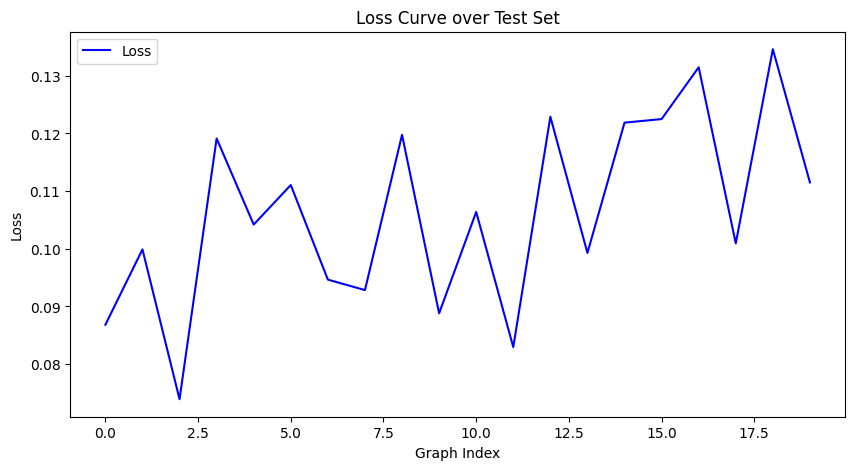

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Loss', color='blue')
plt.xlabel('Graph Index')
plt.ylabel('Loss')
plt.title('Loss Curve over Test Set')
plt.legend()
plt.show()

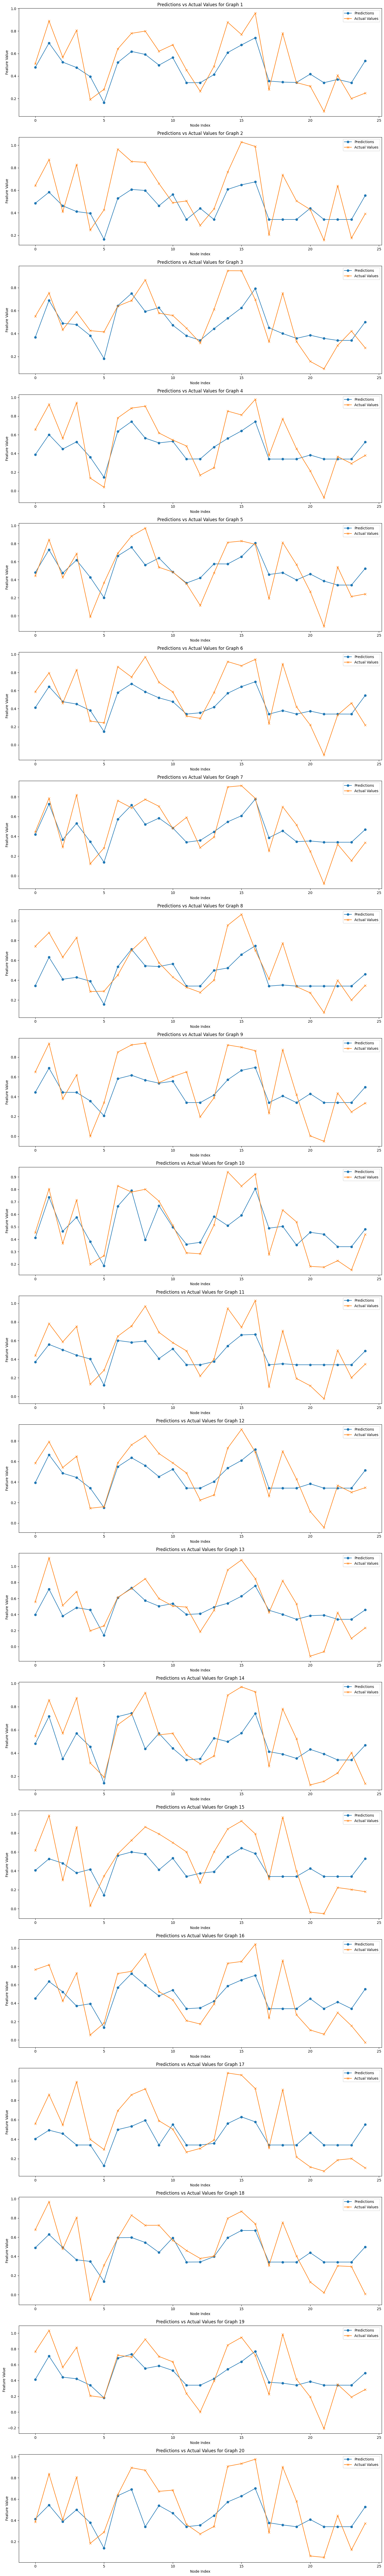

In [40]:
num_graphs = len(all_predictions)
plt.figure(figsize=(15, 5*num_graphs))

for i in range(num_graphs):
    plt.subplot(num_graphs, 1, i+1)
    plt.plot(all_predictions[i], label='Predictions', marker='o')
    plt.plot(all_actual_values[i], label='Actual Values', marker='x')
    plt.xlabel('Node Index')
    plt.ylabel('Feature Value')
    plt.title(f'Predictions vs Actual Values for Graph {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

In [41]:
concatenated_predictions = np.concatenate(all_predictions)
concatenated_all_actual_values = np.concatenate(all_actual_values)

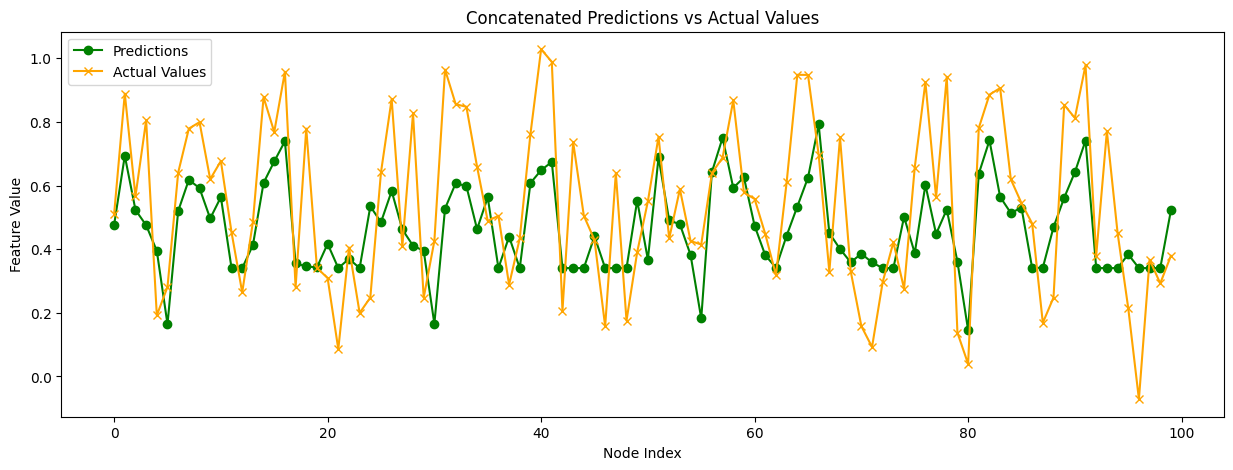

In [42]:
plt.figure(figsize=(15, 5))
plt.plot(concatenated_predictions[:100], label='Predictions', marker='o', color='green')
plt.plot(concatenated_all_actual_values[:100], label='Actual Values', marker='x', color='orange')
plt.xlabel('Node Index')
plt.ylabel('Feature Value')
plt.title('Concatenated Predictions vs Actual Values')
plt.legend()
plt.show()

In [64]:
def predict_feature3(feature3_value):
        poly = PolynomialFeatures(degree=2, include_bias=False)
        # Load the pretrained model
        model = joblib.load('best_model.pkl')
        # Transform the input feature
        feature3_poly = poly.transform([[feature3_value]])
        # Predict using the model
        prediction = model.predict(feature3_poly)

        return prediction

In [65]:
forecasted_graphs=[]

In [79]:
# Generate three random values for each value in predictions
def generate_random_values(predictions):
    random_values = np.random.rand(len(predictions), 3)
    return random_values

In [96]:
import torch
import dgl
import numpy as np

# Generate three random values for each value in predictions
def generate_random_values(predictions):
    random_values = np.random.rand(len(predictions), 3)
    return random_values

def forecasting():
    forecasted_graphs = []
    latest = max(timestamp_graphs.keys())
    latest_graph = timestamp_graphs[latest]

    limit = int(input('Enter number of timestamps to forecast:'))
    
    for i in range(limit):
        features = latest_graph.ndata['feat'][:, :3]
        with torch.no_grad():
            predictions = model.forward(latest_graph, features).squeeze()
            
            feature3_predictions = generate_random_values(predictions)

            # Convert the feature3_predictions to tensor
            feature3_values_tensor = torch.tensor(feature3_predictions, dtype=torch.float32)

            # Ensure predictions_tensor is of correct shape
            predictions_tensor = predictions.unsqueeze(1)

            # Concatenate the new feature tensors
            new_features = torch.cat((feature3_values_tensor, predictions_tensor), dim=1)

            # Create a new graph with the same structure as the latest graph but updated features
            new_graph = dgl.graph(latest_graph.edges())
            new_graph.ndata['feat'] = new_features

            forecasted_graphs.append(new_graph)
            latest_graph = new_graph
    
    return forecasted_graphs

# Example usage
forecasted_graphs = forecasting()


Enter number of timestamps to forecast: 3


In [97]:
forecasted_graphs[1].ndata

{'feat': tensor([[0.6414, 0.7372, 0.6231, 0.3995],
        [0.7324, 0.5711, 0.9329, 0.3406],
        [0.9080, 0.2621, 0.3452, 0.5343],
        [0.4046, 0.3038, 0.5530, 0.4692],
        [0.9354, 0.7820, 0.6157, 0.4972],
        [0.3541, 0.2497, 0.6891, 0.4777],
        [0.7379, 0.0661, 0.7422, 0.5395],
        [0.5296, 0.6206, 0.3124, 0.4227],
        [0.5920, 0.8973, 0.4901, 0.5462],
        [0.8105, 0.7541, 0.1331, 0.5296],
        [0.0599, 0.6951, 0.3188, 0.5926],
        [0.9365, 0.4765, 0.5588, 0.3406],
        [0.7399, 0.8598, 0.0198, 0.3406],
        [0.3615, 0.0111, 0.6875, 0.3406],
        [0.9796, 0.4066, 0.0905, 0.5272],
        [0.5861, 0.4954, 0.1137, 0.6237],
        [0.7074, 0.0147, 0.4178, 0.5049],
        [0.1589, 0.0665, 0.2020, 0.4078],
        [0.1593, 0.3078, 0.4051, 0.3406],
        [0.9485, 0.1998, 0.9309, 0.3406],
        [0.3478, 0.2016, 0.4820, 0.5556],
        [0.1561, 0.3807, 0.6968, 0.3406],
        [0.8169, 0.6795, 0.1391, 0.5014],
        [0.9065, 0.0883, 